In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
fn = 'orders.csv'

In [3]:
# Данные касаются продаж книжного интернет-магазина
!head $fn

DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
23.55%,Хроники Амбера. Том 2,357.0,1,2017-03-19 22:25:20,110.0,169108,602051,1,527.0,911531
4.07%,Хроники Амбера. Том 1,448.0,1,2017-03-19 22:19:58,19.0,1394744,602047,1,618.0,911531
4.17%,Пищеводитель,414.0,1,2017-03-19 20:58:00,65.0,191276,602017,4,1503.0,911587
4.17%,"Аудиокн. Мясников. &quot;Ржавчина&quot;: что делать, чтобы сердце не болело",253.0,1,2017-03-19 20:58:00,65.0,157945,602017,4,1503.0,911587
4.09%,Инфекции. Как защитить себя и своего ребенка,422.0,1,2017-03-19 20:58:00,65.0,205173,602017,4,1503.0,911587
4.17%,О самом главном с доктором Мясниковым,414.0,1,2017-03-19 20:58:00,65.0,189415,602017,4,1503.0,911587
4.12%,Пеппи Длинныйчулок собирается в путь,489.0,1,2017-03-19 20:53:51,42.0,168183,602015,2,1238.0,201724
4.12%,Пеппи Длинныйчулок в стране Веселии,489.0,1,2017-03-19 20:53:51,42.0,186112,602015,2,1238.0,201724
4.09%,Серебряный шар. Драма за сценой,586.0,1,2017-0

# 1. Провести EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных вцелом

In [4]:
df = pd.read_csv(fn, na_values='NaN')
df.head(5)

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
0,23.55%,Хроники Амбера. Том 2,357.00,1,2017-03-19 22:25:20,110.00,169108,602051,1,527.00,911531
1,4.07%,Хроники Амбера. Том 1,448.00,1,2017-03-19 22:19:58,19.00,1394744,602047,1,618.00,911531
2,4.17%,Пищеводитель,414.00,1,2017-03-19 20:58:00,65.00,191276,602017,4,1503.00,911587
3,4.17%,Аудиокн. Мясников. &quot;Ржавчина&quot;: что д...,253.00,1,2017-03-19 20:58:00,65.00,157945,602017,4,1503.00,911587
4,4.09%,Инфекции. Как защитить себя и своего ребенка,422.00,1,2017-03-19 20:58:00,65.00,205173,602017,4,1503.00,911587


In [5]:
# Дубликаты
df.duplicated().sum()

10

In [6]:
df.drop_duplicates(inplace = True)

Представлены следующие данные:

- DISCOUNT_VALUE - величина скидки, %;
- NAME - название книги;
- PRICE - стоимость одного экземпляра книги;
- QUANTITY - количество заказанных экземпляров книги;
- data_inser - дата и время размещения (?) заказа;
- discount - рассчитанная стоимость скидки. Расчётная формула, по-видимому, следующая:
discount = PRICE * DISCOUNT_VALUE / (1 - DISCOUNT_VALUE);
- itemID - идентификатор товара (книги);
- orderID - идентификатор заказа;
- ordered_item_count - количество товаров в данном заказе;
- price - общая стоимость заказа (видимо, с учётом доставки?);
- user_id - идентификатор клиента.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557808 entries, 0 to 557817
Data columns (total 11 columns):
DISCOUNT_VALUE        553771 non-null object
NAME                  557801 non-null object
PRICE                 557808 non-null float64
QUANTITY              557808 non-null int64
date_insert           557808 non-null object
discount              557808 non-null float64
itemID                557808 non-null int64
orderID               557808 non-null int64
ordered_item_count    557808 non-null int64
price                 557808 non-null float64
user_id               557808 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 51.1+ MB


In [8]:
# Количество уникальных пользователей, делавших заказы
df['user_id'].nunique()

76258

In [9]:
# Количество уникальных книг (по id)
df['itemID'].nunique()

51890

In [10]:
df['NAME'].nunique()

74632

Т.к. уникальных id товаров меньше, чем уникальных названий, то скорее всего в названиях встречаются неточности (из-за чего они получаются отличающимися)

In [11]:
# Встречаются такие довольно загадочные данные с отрицательной скидкой
df[df['orderID'] == 601300]

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
190,NaN,"Кыш, Двапортфеля и целая неделя. Кыш и я в Кры...",437.00,1,2017-03-18 11:15:09,-823.00,198440,601300,2,1102.00,910987
191,NaN,В Стране Вечных Каникул. Саша и Шура (вес: 640...,386.00,1,2017-03-18 11:15:09,-823.00,200733,601300,2,1102.00,910987


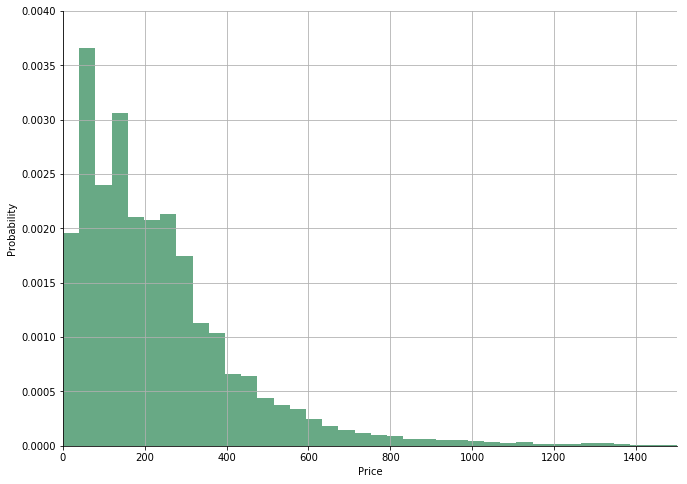

In [12]:
# График распределения цены книги

fig, ax = plt.subplots(1, 1, figsize=(11, 8))

# the histogram of the speed
n, bins, patches = plt.hist(df['PRICE'], 500, normed=1, facecolor='#368d5c', alpha=0.75)

plt.xlabel('Price', fontsize = 10)
plt.ylabel('Probability', fontsize = 10)
plt.axis([0, 1500, 0, 0.004])
plt.grid(True)

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

In [13]:
# Сгруппируем стоимость заказов пользователей
price_by_user = df.groupby(['user_id'])['price'].sum()
price_by_user.describe()

count      76258.00
mean       20461.55
std       238496.76
min            3.00
25%          984.85
50%         3688.00
75%        10833.98
max     31763867.00
Name: price, dtype: float64

In [14]:
# Сгруппируем количество заказов пользователей
ordered_item_count_by_user = df.groupby(['user_id'])['ordered_item_count'].sum()
ordered_item_count_by_user.describe()

count    76258.00
mean        88.89
std        953.18
min          1.00
25%          1.00
50%          9.00
75%         36.00
max     103570.00
Name: ordered_item_count, dtype: float64

Видно, что в данных выделяются некие оптовые покупатели, приобретающие большое количество книг

In [15]:
# Сгруппируем количество заказов для каждой отдельной книги (т.е. сколько раз её покупали)
book_order_count = df.groupby(['itemID'])['QUANTITY'].sum().reset_index().sort_values('QUANTITY', ascending=False)
book_order_count.describe()

,itemID,QUANTITY
count,51890.00,51890.00
mean,493166.01,17.74
std,518404.88,74.59
min,131823.00,1.00
25%,170760.50,2.00
50%,192168.50,5.00
75%,665972.50,14.00
max,1787508.00,3269.00


In [16]:
top5_selling_books = book_order_count.head()
top5_selling_books

,itemID,QUANTITY
34914,294189,3269
41498,721305,2806
40350,712235,2765
50091,1635426,2715
38141,637235,2624


In [17]:
df[df['itemID'].isin(top5_selling_books['itemID'].tolist())]

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
3455,4.2%,География. 8 класс. Атлас,137.00,1,2017-03-19 15:53:10,24.00,712235,601906,4,793.00,911492
14973,10.49%,География. 8 класс. Атлас,107.29,24,2017-03-16 17:46:39,35.71,712235,600357,1,2574.96,109601
15290,0,География. 8 класс. Атлас (вес: 122гр.),114.40,19,2017-03-16 16:44:05,41.20,712235,600306,2,3181.60,105934
16555,4.2%,География. 8 класс. Атлас,143.00,1,2017-03-14 17:28:00,0.00,712235,598723,4,884.00,909377
23764,25.4%,География. 7 класс. Контурные карты,47.00,20,2017-03-26 15:27:21,322.00,637235,607656,7,12290.00,105934
59636,0,География. 7 класс. Контурные карты (вес: 46гр.),47.25,2,2017-03-31 08:33:33,202.75,637235,610226,5,1821.00,105934
64775,4.76%,География. 7 класс. Контурные карты,60.00,1,2017-04-09 15:54:16,44.00,637235,614238,4,1028.00,920446
72630,11.89%,География. 8 класс. Атлас (вес: 122гр.),125.84,15,2017-04-14 15:42:11,85.80,712235,617748,5,10018.00,919443
73308,18.88%,Атлас. 5кл. География. ФГОС (вес: 80гр.),116.00,26,2017-04-12 16:57:30,264.00,294189,616786,6,15938.00,382228
74538,25.87%,География. 8 класс. Атлас,106.00,9,2017-04-12 11:37:25,230.00,712235,616547,4,3019.00,921863


Мы видим, что наиболее продаваемые книги - различные учебники. Особенно популярны почему-то география, история и астрономия

# 2. Спланировать эксперимент 

Задача:
* сегментация товаров + сегментация пользователей (по товарам, по поведению, скидкам и пр.)

Дополнительнительные задачи:
* поиск товаров-заменителей и товаров, дополняющих друг друга
* поиск выбросов среди товаров
* поиск выбросов среди заказов

Эксперимент:
* Составить первичный список признаков, необходимых для решения задачи
* Сгенерировать список новых признаков, которые можно получить из данных
* Применить понижение размерности для визуализации данных
* Применить кластеризацию, визуализировать
* Описание кластера
* Любые другие пункты

Сегментацию товаров выполним по количеству проданных экземпляров. Дополнительно проведём анализ названий книг, вдруг там обнаружится что-нибудь интересно.

Сегментация пользователей - по количеству покупок, по скидкам.

Первичный список признаков, необходимых для решения задачи:
- все, кроме discount

Список новых признаков, которые можно получить из данных:
- частота определённых слов в названиях книг

# 3. Выполнить подготовку данных для построения модели

Выполнить необходимые преобразования данных

In [18]:
# Удалим в столбце скидки знак процента, чтобы данные использовать в числовой форме
df['DISCOUNT_VALUE'] = pd.to_numeric(df['DISCOUNT_VALUE'].str.replace('%', ''))

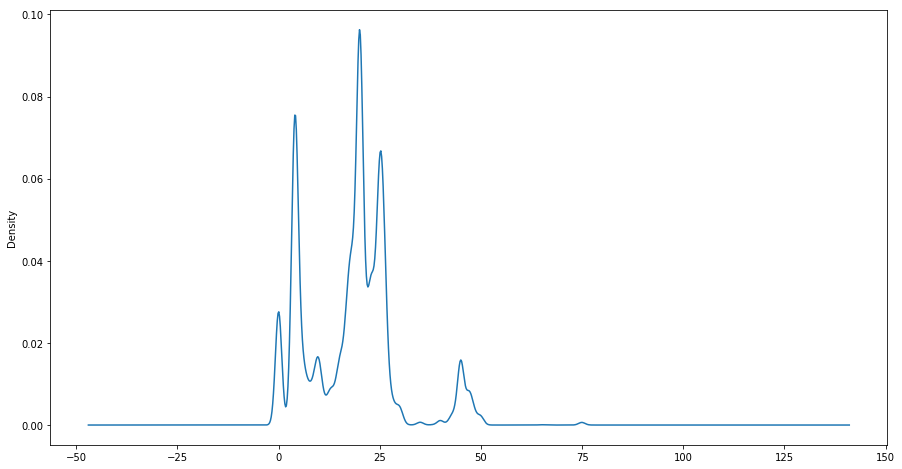

In [19]:
df['DISCOUNT_VALUE'].plot.kde()

В распределении скидки видно несколько пиков, в районе 5, 20 и 40 % => можно ожидать некоторой кластеризации

In [20]:
# Даты преобразуем из строкового представления в формат даты
df['date_insert'] = pd.to_datetime(df['date_insert'])

In [21]:
# Приводим названия книг к нижнему регистру и заменяем отсутствующие значения пустой строкой
df['NAME'] = df['NAME'].map(lambda x: str(x).decode('utf8').lower()).fillna('')
docs = df['NAME'].as_matrix()

In [22]:
# Рассмотрим интенсивность покупок по времени (сгруппируем заказы по дням)
df_group_by_day = df.groupby(df['date_insert'].map(lambda x: x.date()))['ordered_item_count'].sum()
df_group_by_day.describe()

count      203.00
mean     33390.16
std      20624.69
min       4862.00
25%      17962.50
50%      26922.00
75%      43673.50
max     130066.00
Name: ordered_item_count, dtype: float64

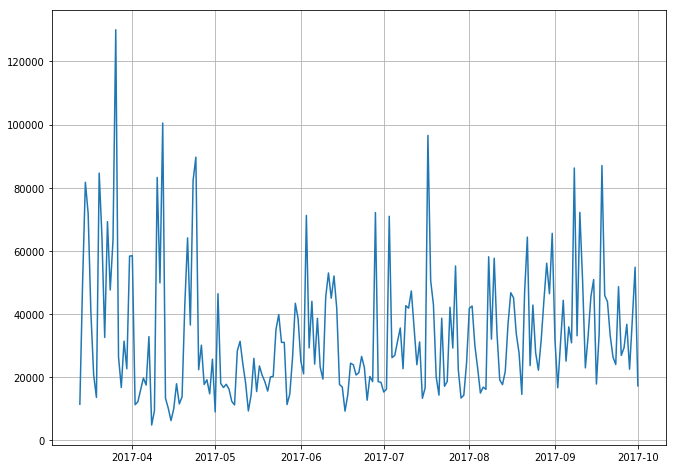

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
plt.grid()
ax.plot(df_group_by_day)

Видим, что никакой особой зависимости не наблюдается, хотя в районе мая-июня всё же заметен некоторый спад. Построим сглаженный график с количеством покупок по месяцам

In [29]:
df_group_by_month = df.groupby(df['date_insert'].map(lambda x: x.month))['ordered_item_count'].sum()
df_group_by_month.describe()

count         8.00
mean     847275.38
std      363933.86
min       17277.00
25%      845946.50
50%      941350.50
75%     1024293.50
max     1179503.00
Name: ordered_item_count, dtype: float64

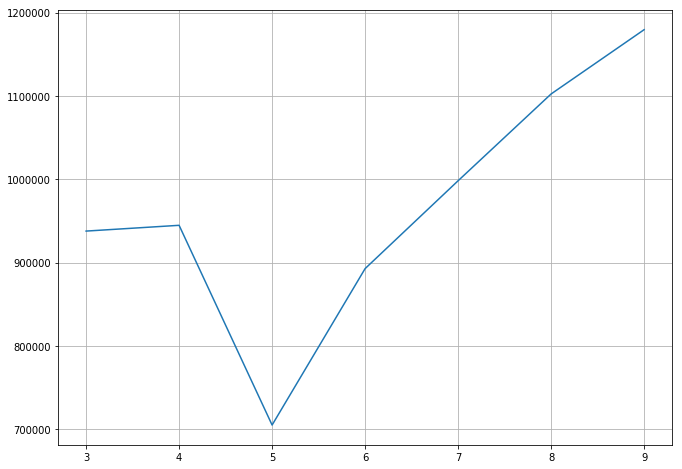

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
plt.grid()
ax.plot(df_group_by_month[:7])

На этом графике спад продаж в мае более заметен. Также виден подъём в сентябре (что, видимо, связано с началом учебного года)

In [34]:
# Чтобы работать с временными данными как с числами, преобразуем их к UNIX-time
df['unix_time'] = pd.DatetimeIndex(df['date_insert']).astype(np.int64)/1000000000
df.head()

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id,unix_time
0,23.55,хроники амбера. том 2,357.00,1,2017-03-19 22:25:20,110.00,169108,602051,1,527.00,911531,1489962320
1,4.07,хроники амбера. том 1,448.00,1,2017-03-19 22:19:58,19.00,1394744,602047,1,618.00,911531,1489961998
2,4.17,пищеводитель,414.00,1,2017-03-19 20:58:00,65.00,191276,602017,4,1503.00,911587,1489957080
3,4.17,аудиокн. мясников. &quot;ржавчина&quot;: что д...,253.00,1,2017-03-19 20:58:00,65.00,157945,602017,4,1503.00,911587,1489957080
4,4.09,инфекции. как защитить себя и своего ребенка,422.00,1,2017-03-19 20:58:00,65.00,205173,602017,4,1503.00,911587,1489957080


#### Выполним стандартизацию числовых признаков

In [35]:
from sklearn.preprocessing import Imputer, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_union, make_pipeline

In [42]:
def get_num_cols(df):
    return df[['DISCOUNT_VALUE', 'PRICE', 'QUANTITY', 'discount', 'ordered_item_count', 'price', 'unix_time']]

def get_not_modified_cols(df):
    return df[['NAME', 'date_insert', 'itemID', 'orderID', 'user_id']]

vec_std = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), StandardScaler()),
    make_pipeline(FunctionTransformer(get_not_modified_cols, validate=False))
])

df_std = vec_std.fit_transform(df)
df_std.shape

(557808, 12)

In [43]:
print(repr(df_std[:2, :]).decode("unicode-escape"))

array([[0.5109046342306376, 0.43623760629522723, -0.12896924751979866,
        -0.39655535527063945, -0.5686650903216658, -0.29926384405373574,
        -1.6934566628269991,
        u'хроники амбера. том 2',
        Timestamp('2017-03-19 22:25:20'), 169108, 602051, 911531],
       [-1.2344873017532243, 0.7836555040284127, -0.12896924751979866,
        -0.4846974730232106, -0.5686650903216658, -0.28726851553151495,
        -1.6935177290304904,
        u'хроники амбера. том 1',
        Timestamp('2017-03-19 22:19:58'), 1394744, 602047, 911531]], dtype=object)


#### Попробуем применить понижение размерности для выделения наиболее важных признаков

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(df_std[:, :7])

pca.explained_variance_ratio_

array([ 0.32150828,  0.17076966,  0.16434017,  0.14865967,  0.11771855,
        0.04663833,  0.03036533])

Видим, что первые 5 компонент отвечают за 92,3 % дисперсии в данных. Уменьшим размерность в соответствии с этим

In [49]:
vec_std = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), StandardScaler())
])

df_numeric = vec_std.fit_transform(df)
df_numeric.shape

(557808, 7)

In [50]:
print(df_numeric[:5, :])

[[ 0.51090463  0.43623761 -0.12896925 -0.39655536 -0.56866509 -0.29926384
  -1.69345666]
 [-1.2344873   0.7836555  -0.12896925 -0.48469747 -0.56866509 -0.28726852
  -1.69351773]
 [-1.22552738  0.65385101 -0.12896925 -0.44014212 -0.41568159 -0.17061065
  -1.69445041]
 [-1.22552738  0.03918858 -0.12896925 -0.44014212 -0.41568159 -0.17061065
  -1.69445041]
 [-1.23269532  0.68439325 -0.12896925 -0.44014212 -0.41568159 -0.17061065
  -1.69445041]]


In [52]:
pca = PCA(n_components = 5)
df_numeric_pca = pca.fit_transform(df_numeric)

df_numeric_pca[:5]

array([[-0.62641582, -0.29468148,  0.63247676, -0.52624647,  1.65513501],
       [-0.93316678, -0.41531683,  2.02461871, -0.32341382,  0.6297799 ],
       [-0.74741047, -0.46508852,  1.98526177, -0.41294855,  0.55927798],
       [-0.69607888, -0.59017232,  1.72705601, -0.88338088,  0.34268857],
       [-0.75091748, -0.45974218,  2.00318879, -0.38974293,  0.5653542 ]])

Каждая строка в массиве df_numeric соответствует заказу одной определённой книги и характеризуется соответствующим ему набору itemID, orderID и user_id. Соответственно, по этим 5-ти числовым признакам мы могли бы попытаться классифицировать соответствующий товар или пользователя. А те товары, у которых одинаковый orderId, мы могли бы назвать "сопутствующими" или "дополняющими" товарами. 

In [53]:
y_item = df['itemID'].as_matrix()
y_user = df['user_id'].as_matrix()
y_order = df['orderID'].as_matrix()

# 4. Провести построение модели 

#### Попробуем использовать кластеризацию без учителя - модели k-means и dbscan, используя числовые данные

In [54]:
from sklearn.cluster import KMeans
from sklearn import metrics

Text(0,0.5,u'inertia')

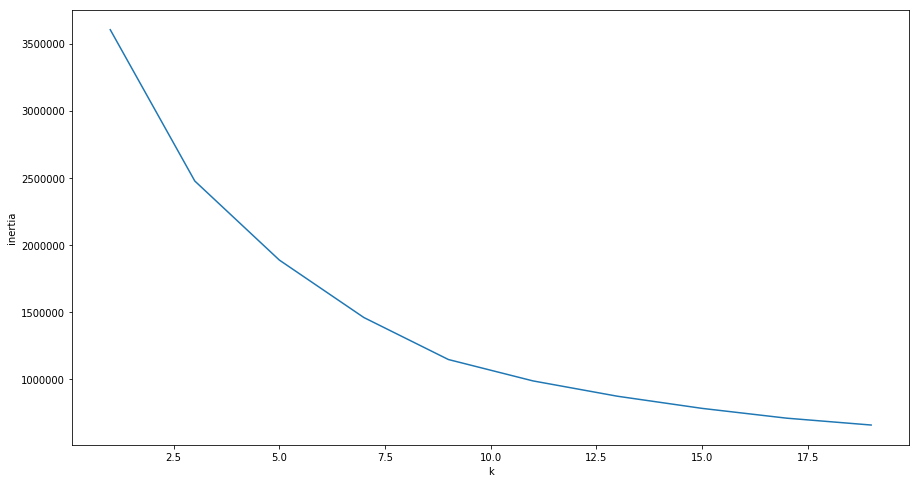

In [55]:
# Т.к. про кластеры в данных нам ничего не известно, по будем варьировать число кластеров в методе k-means

inertia = []
k = range(1, 20, 2)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(df_numeric_pca)
    inertia.append(km.inertia_)
 
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')

По методу локтя возьмём примерное количество кластеров в месте перегиба графика, равное 4 

In [56]:
k_means = KMeans(n_clusters=4).fit(df_numeric_pca)

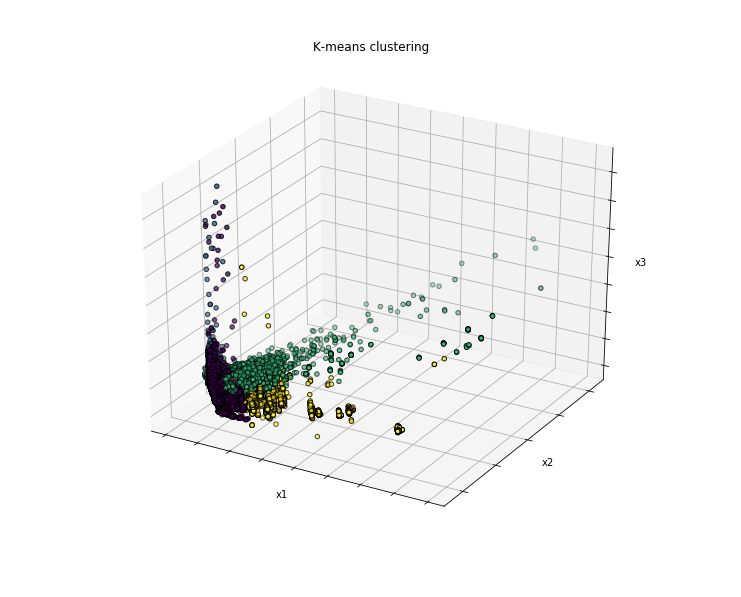

In [57]:
# Визуализируем получившееся разбиение на кластеры
fig = plt.figure(1, figsize=(10, 8))
ax = Axes3D(fig)

ax.scatter(df_numeric_pca[:, 0], df_numeric_pca[:, 1], df_numeric_pca[:, 2],
           c=k_means.labels_.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

ax.set_title('K-means clustering')
ax.dist = 12

In [58]:
df['k_means_label'] = k_means.labels_

#### Попытаемся проанализировать названия книг и сопоставить их с классами k-means

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()

word_bag = count_vec.fit_transform(docs)
print('Кол-во уникальных слов в названиях книг: ' + str(len(count_vec.vocabulary_)))

Кол-во уникальных слов в названиях книг: 37396


In [60]:
# Чтобы напечатать весь словарь
print (repr(count_vec.vocabulary_).decode("unicode-escape"))

{u'уральской': 33948, u'энциклоедия': 36983, u'девятого': 10440, u'бруклина': 6640, u'неправильная': 20939, u'791гр': 2484, u'системы': 29733, u'нормальным': 21344, u'тунисским': 33243, u'настала': 20299, u'пилюли': 23862, u'систему': 29732, u'организм': 22344, u'гиков': 9267, u'эрудит': 37034, u'отстоять': 22874, u'упавшая': 33888, u'производителей': 26454, u'властелин': 7834, u'стеклянном': 31289, u'политическая': 24871, u'рембрандта': 27942, u'славянская': 29981, u'лидьярдом': 17393, u'правым': 25638, u'распутник': 27592, u'воробьям': 8260, u'помпадур': 25087, u'498гр': 2013, u'система': 29724, u'системе': 29727, u'пилюля': 23863, u'узкая': 33613, u'справ': 31034, u'замаранные': 12674, u'коробе': 15983, u'грейс': 9911, u'результат': 27866, u'крайона': 16265, u'манеры': 18225, u'версаль': 7370, u'колдовские': 15480, u'тайных': 32114, u'мудрая': 19671, u'эффективного': 37107, u'счетов': 31953, u'рефлексология': 28017, u'тайный': 32113, u'жозеф': 12289, u'выпотрошенном': 8723, u'транзи

In [61]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
word_bag_tfidf = tfidf_transformer.fit_transform(word_bag)
word_bag_tfidf.shape

(557808, 37396)

In [62]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(word_bag_tfidf, df['k_means_label'])

array([ 292702.,  248743.,    8832.,    7531.])

# 5. Проанализировать результат
получилось или нет, почему, что можно улучшить, можно ли интерпретировать результат

In [64]:
# Найдём, сколько всего книг в каждом классе k-means
clf.class_count_
# Явно по количеству выделяются 1 и 2 классы 

array([ 292702.,  248743.,    8832.,    7531.])

In [65]:
# Найдём общую стоимость продаж книг в каждом классе
df.groupby(['k_means_label'])['price'].sum()
# По объёму продаж классы примерно сопоставимы

k_means_label
0   578541371.49
1   504153518.14
2   226263518.28
3   251398629.64
Name: price, dtype: float64

In [71]:
# Центры кластеров характеризуются следующими значениями числовых признаков

cluster_centers_pca = pca.inverse_transform(k_means.cluster_centers_)

std_scaler = StandardScaler()
std_scaler.fit(get_num_cols(df).dropna())

# центры кластеров (преобразованные обратнов размерные единицы)
cluster_centers = std_scaler.inverse_transform(cluster_centers_pca)

In [72]:
labels = ['DISCOUNT_VALUE', 'PRICE', 'QUANTITY', 'discount', 'ordered_item_count', 'price', 'unix_time']

df_clusters_rows = []

df_clusters_rows.append(cluster_centers[0, :].tolist())
df_clusters_rows.append(cluster_centers[1, :].tolist())
df_clusters_rows.append(cluster_centers[2, :].tolist())
df_clusters_rows.append(cluster_centers[3, :].tolist())

df_clusters = pd.DataFrame.from_records(df_clusters_rows, columns=labels)

df_clusters

,DISCOUNT_VALUE,PRICE,QUANTITY,discount,ordered_item_count,price,unix_time
0,20.60,242.67,1.27,474.44,9.89,1849.18,1502981059.20
1,14.39,246.71,1.14,401.73,11.91,2036.89,1494022223.32
2,22.04,153.46,29.97,399.14,2.52,27647.96,1499595933.43
3,20.29,176.65,0.18,6479.20,121.98,36224.73,1498079623.55


Кластеры характеризуются:

0, 1 - похожи друг на друга. Заказ с небольшой суммой, среднее количество книг в заказе около 10, каждой книги примерно по 1-ой. Похоже на типичный индивидуальный заказ. В классе 0 скидка выше, чем в классе 1;

2 - характеризуется максимальной скидкой. Небольшое количество разных книг в заказе, но каждой книги покупается много экземпляров. Типичный оптовый заказ, например, учебников в школу

3 - много разных книг в рамках одного заказа, и очень большая скидка. Это какие-то странные оптовые заказы, в
которых закупается очень много различных книг. Возможно, какие-то розничные магазины?

In [73]:
df[df['k_means_label'] == 0].head()

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id,unix_time,k_means_label
91893,74.88,идеальные блюда из мультиварки (вес: 424гр.),51.00,1,2017-04-21 01:39:23,219.00,557038,620536,5,481.68,924731,1492738763,0
92927,74.88,идеальные блюда из мультиварки,51.00,1,2017-04-19 16:44:42,304.00,557038,619543,2,102.00,210195,1492620282,0
92928,74.88,блюда в мультиварке для праздников,51.00,1,2017-04-19 16:44:42,304.00,138078,619543,2,102.00,210195,1492620282,0
95294,74.88,чудо-блендер,51.00,1,2017-04-21 10:56:30,747.00,188175,620755,7,1053.00,32128,1492772190,0
95295,65.08,мультиварка. новые рецепты,103.00,1,2017-04-21 10:56:30,747.00,195933,620755,7,1053.00,32128,1492772190,0


In [74]:
df[df['k_means_label'] == 1].head()

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id,unix_time,k_means_label
0,23.55,хроники амбера. том 2,357.00,1,2017-03-19 22:25:20,110.00,169108,602051,1,527.00,911531,1489962320,1
1,4.07,хроники амбера. том 1,448.00,1,2017-03-19 22:19:58,19.00,1394744,602047,1,618.00,911531,1489961998,1
2,4.17,пищеводитель,414.00,1,2017-03-19 20:58:00,65.00,191276,602017,4,1503.00,911587,1489957080,1
3,4.17,аудиокн. мясников. &quot;ржавчина&quot;: что д...,253.00,1,2017-03-19 20:58:00,65.00,157945,602017,4,1503.00,911587,1489957080,1
4,4.09,инфекции. как защитить себя и своего ребенка,422.00,1,2017-03-19 20:58:00,65.00,205173,602017,4,1503.00,911587,1489957080,1


Видим, что в классе 0 собрались товары с максимальной скидкой

In [77]:
df[df['k_means_label'] == 2].head(15)

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id,unix_time,k_means_label
299,4.02,#пастапаста,1065.00,10,2017-03-17 15:46:28,4037.00,196138,600959,8,42544.00,175158,1489765588,2
306,4.08,#неслипнется,512.00,15,2017-03-17 15:46:28,4037.00,188927,600959,8,42544.00,175158,1489765588,2
562,45.06,животные. все обитатели нашей планеты,834.00,23,2017-03-16 17:41:02,684.00,715598,600352,1,19182.00,198448,1489686062,2
570,19.95,чайка. три сестры. вишневый сад (вес: 513гр.),276.00,36,2017-03-16 17:08:14,12.00,219266,600329,1,9936.00,910163,1489684094,2
594,17.22,вселенная (+ наклейки для раскрашивания),298.00,41,2017-03-16 16:08:19,114.00,669491,600274,3,20818.00,910190,1489680499,2
595,17.11,космос (с наклейками),155.00,33,2017-03-16 16:08:19,114.00,706157,600274,3,20818.00,910190,1489680499,2
596,17.39,монстры в космосе,95.00,33,2017-03-16 16:08:19,114.00,190165,600274,3,20818.00,910190,1489680499,2
610,45.05,на линии огня. искусство отвечать на провокаци...,261.00,100,2017-03-16 15:42:54,214.00,181818,600247,1,26100.00,33931,1489678974,2
720,18.27,избранное,78.04,28,2017-03-16 11:18:47,25.96,176329,600035,1,2185.12,910164,1489663127,2
968,4.49,химия. 9 класс. рабочая тетрадь к умк лунина (...,178.00,24,2017-03-15 16:19:17,0.00,181610,599343,1,4272.00,909813,1489594757,2


Здесь собрались детские книги, школьные учебники, и т.д.

In [81]:
df[df['k_means_label'] == 3].head()

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id,unix_time,k_means_label
9827,16.95,как работает google (вес: 782гр.),484.72,1,2017-03-16 10:47:37,4360.67,168979,599999,44,23380.33,908657,1489661257,3
9828,16.90,"игры, в которые играют люди. люди, которые игр...",407.53,1,2017-03-16 10:47:37,4360.67,174113,599999,44,23380.33,908657,1489661257,3
9829,16.85,время-деньги! (вес: 315гр.),226.59,1,2017-03-16 10:47:37,4360.67,173665,599999,44,23380.33,908657,1489661257,3
9830,16.99,пособие по выживанию продавца: как закрывать с...,390.93,1,2017-03-16 10:47:37,4360.67,675611,599999,44,23380.33,908657,1489661257,3
9831,17.08,код экстраординарности. 10 нестандартных спосо...,403.38,1,2017-03-16 10:47:37,4360.67,711832,599999,44,23380.33,908657,1489661257,3


А здесь самые разные книги, но в одном заказе

Попробуем выбрать наугад несколько названий книг с ozon.ru из списка бестселлеров, и проверим, к какому классу их отнесёт обученный классификатор

In [83]:
docs_test = [
    'Хочу и буду. Принять себя, полюбить жизнь и стать счастливым',
    'Империя должна умереть. История русских революций в лицах. 1900-1917',
    'Тайная опора. Привязанность в жизни ребенка',
    'Атлас мира. Максимально подробная информация (чёрн.)',
    'Весёлый лисёнок. Учимся сравнивать. Наклейки',
    'Ботанический атлас по системе Де-Кандоля',
    'Последний вздох Византии',
    'ОГЭ-2018. Обществознание. Типовые экзаменационные варианты. 30 вариантов',
    'Мир и человек. Географический атлас']

X_new_counts = count_vec.transform(docs_test)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted_proba = clf.predict_proba(X_new_tfidf)
predicted = clf.predict(X_new_tfidf)

print(predicted_proba)
print(predicted)

[[  8.37270972e-01   1.61632598e-01   2.40944974e-04   8.55484841e-04]
 [  4.78291359e-01   4.82895724e-01   1.24082084e-02   2.64047086e-02]
 [  6.36367927e-01   3.62519903e-01   1.36477620e-04   9.75692204e-04]
 [  7.06736288e-01   1.48931640e-01   1.10058751e-01   3.42733209e-02]
 [  6.39337887e-01   3.39298352e-01   8.38082626e-03   1.29829354e-02]
 [  4.66802118e-01   5.06455864e-01   1.83853210e-02   8.35669728e-03]
 [  4.40341111e-01   5.40661162e-01   4.06372284e-03   1.49340045e-02]
 [  9.48568664e-01   4.24765210e-02   8.24994156e-03   7.04873879e-04]
 [  5.64546088e-01   4.01091690e-01   3.17514692e-02   2.61075348e-03]]
[0 1 0 0 0 1 1 0 0]


Здесь похоже проблема в том, что в классах 2 и 3 очень мало книг, поэтому классификатор, использующий слова, не может правильно спрогнозировать учебники, а относит все книг к классам 0 и 1, в которых подавляющее число книг (и, соответственно, слов)

# 6. Повторить при необходимости 

# Подсказки

* Проводить EDA и работу с признаками на всем датасете
* Для построения модели отсеивать данные тем или иным способом (обосновать выбор) - уменьшить объем данных для анализа
* Оформлять для сдачи задания все эксперименты (в том числе неудачные). Так мы сможем увидеть процесс работы над заданием
* Не тратить 90% времени на первый этап. Планировать время так, чтобы успеть поработать над моделью (в равной степени над каждым пунктом).